[코드]
후기 데이터셋 이용하여 KOBERT 모델 학습하고, 저장 

In [8]:
import pandas as pd 

In [9]:
data_path = '/home/ubuntu/chatbot/dataset/'

In [10]:
intent_df = pd.read_csv(data_path + 'Wellness_Conversation_intent_train.tsv', sep='\t')
intent_df

,id,intent,context,label
0,11122,초조함,내 미래를 생각하니까 너무 갑갑해,10
1,3694,외로움,울적해지지 않으려고 해도 왜 이렇게 울적한지,2
2,3391,슬픔,볼때마다 안쓰럽고 슬프고.,1
3,15876,자신감저하,내가 많이 위축된 거 같아,14
4,2858,슬픔,유리병 깨서 손목 긋고 발로 밟고 피 흘리면서 오열을 했어,1
...,...,...,...,...
12587,3786,외로움,임신 중 주말근무 때문에 이건 사람이 사는 게 아니다,2
12588,16917,자존감저하,유산했다고 시어머니가 죄인 취급을 하니까 자존감이 떨어지는것 같아,15
12589,15507,죄책감,요즘 자소서 쓰는데 자소서만 봐도 후회만 돼요.,12
12590,12452,초조함,근데 의사 말 듣고 나니까 엄청 걱정이 돼요.,10


In [11]:
intent_list = list(intent_df['intent'].unique())
intent_list

['초조함',
 '외로움',
 '슬픔',
 '자신감저하',
 '불면',
 '죄책감',
 '자살충동',
 '절망감',
 '식욕저하',
 '분노',
 '불안',
 '피로',
 '우울감',
 '식욕증가',
 '무기력',
 '감정조절이상',
 '집중력저하',
 '자존감저하',
 '상실감']

##### KoBERT 실행환경 구축

In [12]:
# !pip install ipywidgets  # for vscode
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [13]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [14]:
## CPU
# device = torch.device("cpu")

## GPU
device = torch.device("cuda:0")

In [15]:
device

device(type='cuda', index=0)

In [16]:
bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")   # BERT 모델 가져오기

using cached model. /home/ubuntu/chatbot/code/.cache/kobert_v1.zip
using cached model. /home/ubuntu/chatbot/code/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [17]:
dataset_train = nlp.data.TSVDataset(data_path + 'Wellness_Conversation_intent_train.tsv', field_indices=[2, 3], num_discard_samples=1)
dataset_val = nlp.data.TSVDataset(data_path + 'Wellness_Conversation_intent_val.tsv', field_indices=[2, 3], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset(data_path + 'Wellness_Conversation_intent_test.tsv', field_indices=[2, 3], num_discard_samples=1)

In [18]:
list(dataset_test[0])

['급 기억력 감퇴 와서 진심 우울해', '0']

In [19]:
tokenizer = get_tokenizer()   # 토크나이저 선언 
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)   # token 설정

using cached model. /home/ubuntu/chatbot/code/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [20]:
dataset_train, len(dataset_train)

(<gluonnlp.data.dataset.TSVDataset at 0x7f2584d35dd0>, 12592)

In [21]:
# BERT Dataset 클래스 생성 
class BERTDataset(Dataset):   
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [22]:
# 파라미터 설정 
max_len = 64     # 토큰 최대 길이 
batch_size = 64   # 배치 사이즈 
warmup_ratio = 0.1   # 웜-업 비율 
num_epochs = 50   # 학습 수  
max_grad_norm = 1   # gradient 정규화 최대값 
log_interval = 200   # interval 간격
learning_rate =  5e-5   # 학습률 

In [23]:
len(dataset_train), dataset_train

(12592, <gluonnlp.data.dataset.TSVDataset at 0x7f2584d35dd0>)

In [24]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)   # 학습 데이터셋 생성 
data_val = BERTDataset(dataset_val, 0, 1, tok, max_len, True, False)   # 테스트 데이터셋 생성 
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)   # 테스트 데이터셋 생성 

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [25]:
# BERT Classifier 클래스 생성 
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=len(intent_list),
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()    # 부모 클래스 생성자 초기화 
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)   # 선형 분류기 생성 
        if dr_rate:   # 드랍아웃 
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask \
                              = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [26]:
# 사전훈련된 BERT 모델 생성 
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)  

In [27]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)   # 웜업 스텝 설정 

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/home/ubuntu/anaconda3/envs/chatbot/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [28]:
def calc_accuracy(X,Y):
    print('acc:',len(X), len(Y), type(X), type(Y))
    max_vals, max_indices = torch.max(X, 1)
    print('acc2:',max_vals, max_indices)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [29]:
train_acc_list_50 = []
val_acc_list_50 = []

for e in range(num_epochs):
    train_acc = 0.0
    val_acc = 0.0
    batch = [] 
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        print(f'batch: {batch_id}')
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        # print(f'out: {len(out[0]), len(out), out}')
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        print(batch_id)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list_50.append(train_acc / (batch_id+1))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        val_acc += calc_accuracy(out, label)
    print("epoch {} val acc {}".format(e+1, val_acc / (batch_id+1)))
    val_acc_list_50.append(val_acc / (batch_id+1))

  0%|          | 0/197 [00:00<?, ?it/s]

batch: 0
acc: 64 64 <class 'torch.Tensor'> <class 'torch.Tensor'>
acc2: tensor([0.7062, 0.3558, 0.6850, 0.4952, 0.7771, 0.4983, 0.3735, 0.8425, 1.0121,
        0.7469, 0.7519, 0.9367, 0.4704, 0.6444, 0.8843, 0.5882, 0.6098, 0.7130,
        0.5456, 0.7461, 0.5212, 0.6441, 0.4825, 1.0779, 0.8180, 0.5735, 0.6924,
        0.6954, 0.4959, 0.5019, 0.8568, 0.5977, 0.8542, 0.8003, 0.3846, 0.6607,
        0.7931, 0.5042, 0.6516, 0.4025, 0.5832, 0.6037, 0.5970, 0.4757, 0.5076,
        0.6437, 0.5191, 0.5123, 0.2997, 0.6320, 0.5854, 1.0656, 0.6752, 0.5884,
        0.5386, 0.6615, 0.6409, 0.5671, 0.3653, 0.3295, 0.8494, 0.7370, 0.3740,
        0.5774], device='cuda:0', grad_fn=<MaxBackward0>) tensor([ 3,  0,  8,  8,  8, 11, 13,  8,  8, 11,  8,  3, 10,  2,  8,  5, 11,  5,
         8,  3,  3,  8,  8,  8, 16,  8,  3,  6, 18, 13,  0,  7,  8,  8, 12, 10,
        12,  8,  8,  7, 18,  3,  6, 18, 12,  3, 18, 16,  8,  6, 18,  3, 10,  7,
         8, 10,  3,  8, 11, 11,  8,  8,  8, 18], device='cuda:0')
0
ep

acc: 64 64 <class 'torch.Tensor'> <class 'torch.Tensor'>
acc2: tensor([1.0494, 0.8683, 0.3024, 0.8101, 0.4454, 0.3696, 0.7055, 0.6389, 0.7827,
        0.8210, 0.5814, 0.7477, 1.2187, 0.5231, 0.8580, 0.7054, 0.4962, 0.7506,
        0.6125, 0.7227, 0.5418, 1.0342, 0.7278, 1.0053, 0.8127, 0.4169, 0.6654,
        0.7065, 0.4500, 0.8896, 0.4835, 0.7187, 0.7801, 0.6602, 0.6961, 0.7891,
        0.6083, 1.1516, 0.5097, 0.8731, 0.5641, 0.6569, 0.4195, 0.6662, 0.3870,
        0.4197, 0.7752, 0.6617, 0.5517, 0.6995, 0.7227, 0.6867, 0.4310, 0.3761,
        0.5029, 0.5780, 0.9070, 0.8700, 0.3836, 0.3816, 0.5838, 1.0213, 0.7984,
        0.8256], device='cuda:0', grad_fn=<MaxBackward0>) tensor([10,  3,  7,  1,  8,  8,  8, 10, 10,  3, 18, 18,  3,  5,  5,  6,  5, 10,
        18,  0, 13,  8, 12,  5,  8, 18, 18,  3, 11,  8,  6, 18,  3,  3,  3, 10,
        13, 15, 12, 16,  8, 16, 13,  3,  8,  0, 12,  2,  8, 12,  1,  6, 11,  8,
         6,  8,  3, 18,  6, 11,  3,  8, 10,  8], device='cuda:0')
9
batch: 10
a

acc: 64 64 <class 'torch.Tensor'> <class 'torch.Tensor'>
acc2: tensor([0.7322, 0.9194, 0.8524, 0.4687, 0.8424, 0.3836, 0.6630, 0.7753, 0.8811,
        0.5987, 0.3697, 0.5369, 0.4676, 0.4784, 0.7935, 0.6532, 0.9770, 0.6028,
        0.7261, 0.7883, 1.0548, 0.5325, 0.5836, 0.6904, 0.4845, 1.0470, 0.4183,
        0.5611, 0.3362, 0.3379, 1.1443, 0.6676, 0.3445, 0.4531, 0.6480, 0.7324,
        0.5979, 0.6077, 0.7757, 0.4047, 0.6073, 0.3974, 0.6754, 0.8163, 0.5240,
        0.5099, 0.7624, 0.4008, 0.3734, 0.4258, 0.6860, 0.6712, 0.5419, 0.8374,
        0.9080, 0.6670, 0.6842, 0.6360, 0.5184, 0.4975, 0.6906, 0.5034, 0.8149,
        0.6488], device='cuda:0', grad_fn=<MaxBackward0>) tensor([18,  3,  0,  3,  8, 18,  8,  8, 15, 12, 12,  2, 17, 15,  0, 18,  3, 18,
        18,  4,  3,  3, 16,  3,  3, 12, 16,  8,  7, 11,  3,  8,  6,  6, 12,  3,
         4, 10,  3,  8,  5, 18,  8, 13,  2,  8,  3,  6, 18, 18,  3,  8, 15, 10,
         6, 10,  6, 18,  5,  4, 18,  8,  8,  3], device='cuda:0')
18
batch: 19


acc: 64 64 <class 'torch.Tensor'> <class 'torch.Tensor'>
acc2: tensor([0.5438, 0.6118, 0.3242, 0.6356, 0.6075, 0.3657, 0.5667, 0.8426, 0.5967,
        0.6809, 0.8243, 0.6638, 0.5408, 0.9854, 0.6155, 0.8010, 0.8352, 0.4312,
        0.5112, 0.4418, 0.7764, 0.7094, 0.7592, 0.4344, 0.5144, 0.4298, 0.7863,
        0.7011, 0.4972, 0.6433, 0.8628, 0.7182, 0.5826, 0.7483, 0.5449, 0.6416,
        0.5686, 0.8316, 0.8321, 0.6577, 0.7654, 0.8134, 0.7537, 0.6319, 0.6524,
        0.3380, 0.7408, 0.7445, 0.4637, 0.7440, 0.2573, 0.4696, 1.0600, 0.6289,
        0.4256, 0.7606, 0.4047, 0.4143, 0.7923, 0.4506, 0.6274, 0.5649, 0.9237,
        0.7013], device='cuda:0', grad_fn=<MaxBackward0>) tensor([16, 18, 11,  8,  4,  5,  6, 12,  8,  1, 16,  3, 12,  8,  1,  3,  8,  3,
        15,  5, 10, 18, 10, 15,  6,  8,  8, 18, 13,  8, 10, 18, 12, 12,  8, 18,
         5, 18,  8, 12,  3, 12, 15,  3,  8,  1,  3,  3,  3,  3, 10,  5, 18,  7,
        10, 12, 12, 17,  3, 18,  3, 12, 10,  3], device='cuda:0')
27
batch: 28


acc: 64 64 <class 'torch.Tensor'> <class 'torch.Tensor'>
acc2: tensor([0.5151, 0.4212, 0.6872, 0.7076, 0.3962, 0.8656, 0.6426, 0.7472, 0.8611,
        0.4887, 0.6381, 0.6075, 0.4767, 0.8687, 0.8357, 0.4623, 0.4201, 0.8126,
        0.7714, 0.4631, 0.8167, 0.5610, 0.9970, 0.7001, 0.7392, 0.3687, 0.4980,
        0.4891, 0.4363, 0.6100, 0.5117, 0.5871, 0.5913, 0.6563, 0.6678, 0.6410,
        1.1003, 0.2726, 0.4186, 0.5481, 0.6290, 0.5595, 0.5113, 0.4188, 0.5543,
        0.4540, 0.5646, 0.6443, 0.5625, 0.4622, 0.3525, 0.5407, 0.9260, 1.0122,
        0.9254, 0.5402, 0.8638, 0.7386, 0.6798, 0.6313, 0.2405, 0.6518, 0.6940,
        0.6817], device='cuda:0', grad_fn=<MaxBackward0>) tensor([11, 16,  6, 18, 16, 10,  8,  3,  7,  4, 12,  8,  5,  3,  8, 16,  5,  3,
         3, 12,  8,  3, 18, 16,  3,  8, 10, 10,  0,  7, 10, 10,  0,  3,  8,  3,
         3, 11, 18,  0,  3,  8,  6, 12,  5, 18, 18,  8, 10,  8, 10, 11,  3, 10,
         3, 12, 18,  3,  8, 11,  4, 10,  3,  8], device='cuda:0')
36
batch: 37


KeyboardInterrupt: 

In [22]:
len(val_acc_list_50), len(train_acc_list_50)

(50, 50)

In [23]:
val_acc_list_50

[0.19247596153846153,
 0.5544951923076923,
 0.7181490384615384,
 0.7775240384615384,
 0.7946875,
 0.8125240384615384,
 0.8047115384615384,
 0.8240865384615383,
 0.83125,
 0.8384375,
 0.8216105769230769,
 0.8328125,
 0.8297596153846153,
 0.838125,
 0.8434375,
 0.8368990384615383,
 0.845625,
 0.8403125,
 0.83875,
 0.84,
 0.8384855769230769,
 0.8481490384615384,
 0.8406490384615384,
 0.8475240384615383,
 0.8478125,
 0.8459615384615384,
 0.84625,
 0.8475240384615383,
 0.8425,
 0.8490865384615384,
 0.8450240384615384,
 0.8475240384615383,
 0.8469230769230769,
 0.8484375,
 0.85125,
 0.8525,
 0.854375,
 0.85125,
 0.848125,
 0.8484615384615384,
 0.85,
 0.848125,
 0.8509375,
 0.853125,
 0.8515625,
 0.8515625,
 0.851875,
 0.8521875,
 0.8521875,
 0.8521875]

In [24]:
# 10번 학습 
# test_acc_list, train_acc_list 

# 50번 학습 
test_acc_list_50, train_acc_list_50

NameError: name 'test_acc_list_50' is not defined

In [34]:
epochs_10 = list(range(0, 10))
epochs_50 = list(range(0, 50))

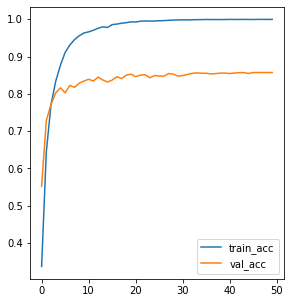

In [36]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(list(range(len(train_acc_list_50))), train_acc_list_50, label='train_acc')
plt.plot(list(range(len(val_acc_list_50))), val_acc_list_50, label='val_acc')

plt.legend()
plt.show()

In [30]:
X_test = pd.read_csv(data_path + 'Wellness_Conversation_intent_test.tsv', sep='\t')

In [31]:
# 실제 감성분석 해보기 
X_test

,id,intent,context,label
0,776,우울감,급 기억력 감퇴 와서 진심 우울해,0
1,18689,자살충동,자책감으로 평생을 살라고 유서도 써놓고 옆에 뒀어.,17
2,18994,불안,긴장감 때문에 힘들다,18
3,12983,초조함,신경질이 나는데 그 사람 옷을 벗겨주고는 침대에서 재웠어요.,10
4,6285,무기력,아무 것도 하기 싫어서 그냥 누워만 있고…,4
...,...,...,...,...
3931,12206,초조함,누굴 만나면 어떻게 얘기해야 하나 걱정도 되고…,10
3932,16000,자신감저하,지금은 내가 할 수 있는게 아무것도 없다는 생각이 많아.,14
3933,13112,초조함,다른 애들보다 두 배로 신경 써줘야 하니까 그것도 너무 짜증나지.,10
3934,4847,분노,이런 지질한 놈이랑 내가 왜 살아야 하나 몰라…,3


In [32]:
load_model = torch.load(data_path + 'BERT_intent_model_50.pt')
load_model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
load_model.load_state_dict(torch.load(data_path + 'BERT_intent_model_50.pt'))

<All keys matched successfully>

In [33]:
comments = X_test['context']
comments

0                                 급 기억력 감퇴 와서 진심 우울해
1                       자책감으로 평생을 살라고 유서도 써놓고 옆에 뒀어.
2                                        긴장감 때문에 힘들다
3                  신경질이 나는데 그 사람 옷을 벗겨주고는 침대에서 재웠어요.
4                            아무 것도 하기 싫어서 그냥 누워만 있고…
                            ...                     
3931                      누굴 만나면 어떻게 얘기해야 하나 걱정도 되고…
3932                 지금은 내가 할 수 있는게 아무것도 없다는 생각이 많아.
3933            다른 애들보다 두 배로 신경 써줘야 하니까 그것도 너무 짜증나지.
3934                      이런 지질한 놈이랑 내가 왜 살아야 하나 몰라…
3935    친구들이랑 대화를 할 때도 누가 녹취를 하는 느낌이 들어서 말을 제대로 못하겠어
Name: context, Length: 3936, dtype: object

In [34]:
y_true = X_test['label']

In [35]:
import pandas as pd

# 위에서 설정한 tok, max_len, batch_size, device를 그대로 입력
# comment : 예측하고자 하는 텍스트 데이터 리스트
def getSentimentValue(comment, tok, max_len, batch_size, device):
    comments_list = [] # 텍스트 데이터를 담을 리스트
    main_list = [] # 대분류 카테고리 값을 담을 리스트
    
    for c in comment: # 모든 댓글
        comments_list.append( [c, 5] ) # [댓글, 임의의 양의 정수값] 설정
        
    pdData = pd.DataFrame(comments_list, columns = [['context', 'intent']] )
    pdData = pdData.values
    test_set = BERTDataset(pdData, 0, 1, tok, max_len, True, False) 
    test_input = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=5)
    
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_input):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length 
    
        # 이때, out이 예측 결과 리스트
        out = load_model(token_ids, valid_length, segment_ids)

        for pred in out: 
            main_list.append(np.argmax(pred.detach().cpu()))
        
    return main_list # 텍스트 데이터에 1대1 매칭되는 감성값 리스트 반환

In [36]:
y_pred = getSentimentValue(comments, tok, max_len, batch_size, device)   # tok, max_len, batch_size, device

In [37]:
y_true

0        0
1       17
2       18
3       10
4        4
        ..
3931    10
3932    14
3933    10
3934     3
3935    15
Name: label, Length: 3936, dtype: int64

In [38]:
len(y_true), len(y_pred)

(3936, 3936)

In [39]:
y_pred = list(map(int, y_pred)) 
# y_pred

In [40]:
y_pred[0]

0

In [41]:
from sklearn.metrics import precision_score , recall_score , confusion_matrix, f1_score, classification_report

confusion_mt = pd.DataFrame(confusion_matrix(y_true, y_pred))
confusion_mt 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,278,4,3,2,7,0,1,4,0,8,4,1,6,0,0,8,1,3,1
1,3,296,5,6,6,1,0,1,0,4,11,0,14,0,0,2,6,0,3
2,3,10,120,1,9,1,0,1,0,0,4,1,0,0,0,1,1,2,1
3,3,8,1,172,2,4,0,0,1,2,10,0,4,0,1,3,2,4,0
4,8,4,1,3,197,3,0,3,0,6,6,12,1,1,5,2,3,3,0
5,3,4,2,4,0,32,1,0,1,0,4,0,1,0,2,0,0,0,0
6,0,1,0,0,0,0,42,0,0,0,0,0,1,0,0,0,0,0,0
7,1,1,0,1,4,0,0,194,12,2,3,0,1,0,0,0,0,0,0
8,0,0,1,0,1,1,0,3,77,2,1,1,0,0,0,0,0,0,0
9,2,2,1,0,0,0,0,1,1,343,8,8,0,0,0,1,0,1,5


In [42]:
confusion_mt.columns = intent_list 
confusion_mt.index = intent_list

In [43]:
confusion_mt

,초조함,외로움,슬픔,자신감저하,불면,죄책감,자살충동,절망감,식욕저하,분노,불안,피로,우울감,식욕증가,무기력,감정조절이상,집중력저하,자존감저하,상실감
초조함,278,4,3,2,7,0,1,4,0,8,4,1,6,0,0,8,1,3,1
외로움,3,296,5,6,6,1,0,1,0,4,11,0,14,0,0,2,6,0,3
슬픔,3,10,120,1,9,1,0,1,0,0,4,1,0,0,0,1,1,2,1
자신감저하,3,8,1,172,2,4,0,0,1,2,10,0,4,0,1,3,2,4,0
불면,8,4,1,3,197,3,0,3,0,6,6,12,1,1,5,2,3,3,0
죄책감,3,4,2,4,0,32,1,0,1,0,4,0,1,0,2,0,0,0,0
자살충동,0,1,0,0,0,0,42,0,0,0,0,0,1,0,0,0,0,0,0
절망감,1,1,0,1,4,0,0,194,12,2,3,0,1,0,0,0,0,0,0
식욕저하,0,0,1,0,1,1,0,3,77,2,1,1,0,0,0,0,0,0,0
분노,2,2,1,0,0,0,0,1,1,343,8,8,0,0,0,1,0,1,5


In [44]:
f1 = round(f1_score(y_true, y_pred, average='micro'), 3) 
f1

0.845

In [45]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [46]:
multiclass_roc_auc_score(y_true, y_pred)

0.9117750931673644

In [47]:
intent_list

['초조함',
 '외로움',
 '슬픔',
 '자신감저하',
 '불면',
 '죄책감',
 '자살충동',
 '절망감',
 '식욕저하',
 '분노',
 '불안',
 '피로',
 '우울감',
 '식욕증가',
 '무기력',
 '감정조절이상',
 '집중력저하',
 '자존감저하',
 '상실감']

In [48]:
intent_idx = list(range(len(intent_list)))
intent_idx

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [49]:
cr = classification_report(y_true, y_pred).split('\n')
cr

['              precision    recall  f1-score   support',
 '',
 '           0       0.87      0.84      0.86       331',
 '           1       0.83      0.83      0.83       358',
 '           2       0.88      0.77      0.82       155',
 '           3       0.82      0.79      0.81       217',
 '           4       0.79      0.76      0.78       258',
 '           5       0.57      0.59      0.58        54',
 '           6       0.93      0.95      0.94        44',
 '           7       0.92      0.89      0.90       219',
 '           8       0.83      0.89      0.86        87',
 '           9       0.88      0.92      0.90       373',
 '          10       0.84      0.89      0.87       540',
 '          11       0.88      0.90      0.89       249',
 '          12       0.81      0.78      0.80       236',
 '          13       0.94      0.92      0.93        49',
 '          14       0.69      0.72      0.70        64',
 '          15       0.86      0.85      0.85       245',
 '       

In [50]:
clr_df = []

for idx, line in enumerate(cr):
    clr_df.append([])
    if line == '':
        continue
    
    word_list = line.strip().split(' ')
    
    for word in word_list:
        if word != '':
            clr_df[idx].append(word)

clr_df

[['precision', 'recall', 'f1-score', 'support'],
 [],
 ['0', '0.87', '0.84', '0.86', '331'],
 ['1', '0.83', '0.83', '0.83', '358'],
 ['2', '0.88', '0.77', '0.82', '155'],
 ['3', '0.82', '0.79', '0.81', '217'],
 ['4', '0.79', '0.76', '0.78', '258'],
 ['5', '0.57', '0.59', '0.58', '54'],
 ['6', '0.93', '0.95', '0.94', '44'],
 ['7', '0.92', '0.89', '0.90', '219'],
 ['8', '0.83', '0.89', '0.86', '87'],
 ['9', '0.88', '0.92', '0.90', '373'],
 ['10', '0.84', '0.89', '0.87', '540'],
 ['11', '0.88', '0.90', '0.89', '249'],
 ['12', '0.81', '0.78', '0.80', '236'],
 ['13', '0.94', '0.92', '0.93', '49'],
 ['14', '0.69', '0.72', '0.70', '64'],
 ['15', '0.86', '0.85', '0.85', '245'],
 ['16', '0.83', '0.72', '0.77', '144'],
 ['17', '0.83', '0.88', '0.85', '129'],
 ['18', '0.86', '0.91', '0.88', '184'],
 [],
 ['accuracy', '0.85', '3936'],
 ['macro', 'avg', '0.83', '0.83', '0.83', '3936'],
 ['weighted', 'avg', '0.85', '0.85', '0.84', '3936'],
 []]

In [51]:
clr_df[-2][0] = ' '.join([clr_df[-2][0], clr_df[-2][1]])
clr_df[-3][0] = ' '.join([clr_df[-3][0], clr_df[-3][1]])
clr_df[-4].insert(1, ' ')
clr_df[-4].insert(2, ' ')
clr_df[0].insert(0, 'index')

In [52]:
clr_df[-2].pop(1)
clr_df[-3].pop(1)
clr_df.pop(1)
clr_df.pop(-1)
clr_df.pop(-4)
clr_df

[['index', 'precision', 'recall', 'f1-score', 'support'],
 ['0', '0.87', '0.84', '0.86', '331'],
 ['1', '0.83', '0.83', '0.83', '358'],
 ['2', '0.88', '0.77', '0.82', '155'],
 ['3', '0.82', '0.79', '0.81', '217'],
 ['4', '0.79', '0.76', '0.78', '258'],
 ['5', '0.57', '0.59', '0.58', '54'],
 ['6', '0.93', '0.95', '0.94', '44'],
 ['7', '0.92', '0.89', '0.90', '219'],
 ['8', '0.83', '0.89', '0.86', '87'],
 ['9', '0.88', '0.92', '0.90', '373'],
 ['10', '0.84', '0.89', '0.87', '540'],
 ['11', '0.88', '0.90', '0.89', '249'],
 ['12', '0.81', '0.78', '0.80', '236'],
 ['13', '0.94', '0.92', '0.93', '49'],
 ['14', '0.69', '0.72', '0.70', '64'],
 ['15', '0.86', '0.85', '0.85', '245'],
 ['16', '0.83', '0.72', '0.77', '144'],
 ['17', '0.83', '0.88', '0.85', '129'],
 ['18', '0.86', '0.91', '0.88', '184'],
 ['accuracy', ' ', ' ', '0.85', '3936'],
 ['macro avg', '0.83', '0.83', '0.83', '3936'],
 ['weighted avg', '0.85', '0.85', '0.84', '3936']]

In [53]:
clr_df = pd.DataFrame(clr_df[1:], columns=clr_df[0])
clr_df

,index,precision,recall,f1-score,support
0,0,0.87,0.84,0.86,331
1,1,0.83,0.83,0.83,358
2,2,0.88,0.77,0.82,155
3,3,0.82,0.79,0.81,217
4,4,0.79,0.76,0.78,258
5,5,0.57,0.59,0.58,54
6,6,0.93,0.95,0.94,44
7,7,0.92,0.89,0.90,219
8,8,0.83,0.89,0.86,87
9,9,0.88,0.92,0.90,373


In [54]:
clr_df.index = clr_df['index']

del clr_df['index']
clr_df

,precision,recall,f1-score,support
index,,,,
0,0.87,0.84,0.86,331
1,0.83,0.83,0.83,358
2,0.88,0.77,0.82,155
3,0.82,0.79,0.81,217
4,0.79,0.76,0.78,258
5,0.57,0.59,0.58,54
6,0.93,0.95,0.94,44
7,0.92,0.89,0.90,219
8,0.83,0.89,0.86,87


In [55]:
len(clr_df)

22

In [57]:
clr_df_1 = clr_df[:11]
clr_df_2 = clr_df[11:]

len(clr_df_1), len(clr_df_2)

(11, 11)

In [67]:
clr_df_1

,precision,recall,f1-score,support
index,,,,
0,0.87,0.84,0.86,331
1,0.83,0.83,0.83,358
2,0.88,0.77,0.82,155
3,0.82,0.79,0.81,217
4,0.79,0.76,0.78,258
5,0.57,0.59,0.58,54
6,0.93,0.95,0.94,44
7,0.92,0.89,0.90,219
8,0.83,0.89,0.86,87


In [60]:
clr_df_2

,precision,recall,f1-score,support
index,,,,
11,0.88,0.90,0.89,249
12,0.81,0.78,0.80,236
13,0.94,0.92,0.93,49
14,0.69,0.72,0.70,64
15,0.86,0.85,0.85,245
16,0.83,0.72,0.77,144
17,0.83,0.88,0.85,129
18,0.86,0.91,0.88,184
accuracy,,,0.85,3936


In [68]:
clr_df.sort_values(by='f1-score',ascending=False)

,precision,recall,f1-score,support
index,,,,
6,0.93,0.95,0.94,44
13,0.94,0.92,0.93,49
9,0.88,0.92,0.90,373
7,0.92,0.89,0.90,219
11,0.88,0.90,0.89,249
18,0.86,0.91,0.88,184
10,0.84,0.89,0.87,540
8,0.83,0.89,0.86,87
0,0.87,0.84,0.86,331


In [69]:
intent_idx

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [70]:
from sklearn.preprocessing import label_binarize 

y_true = label_binarize(y_true, classes=intent_idx)
y_pred = label_binarize(y_pred, classes=intent_idx)

In [71]:
y_true

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [72]:
y_pred

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [103]:
from sklearn.metrics import roc_curve, auc

n_classes = 19
fpr = dict()
tpr = dict()
roc_auc = dict() 

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


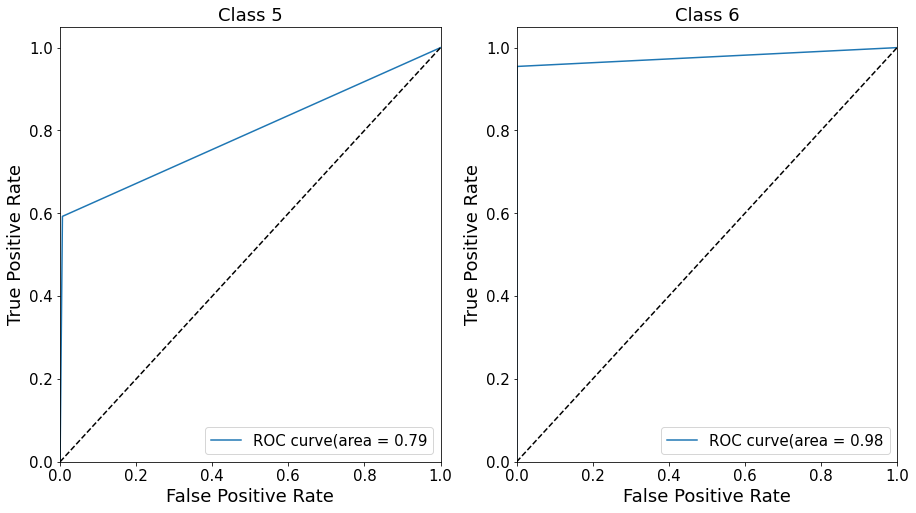

In [107]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(15, 8))
val = 0

# font = {'size': 15}
# plt.rc('font', **font)
plt.rcParams.update({'font.size': 15, 'font.weight': 'normal'})

for idx, i in enumerate(range(n_classes)):
    if idx == 6 or idx == 5: 
        plt.subplot(121+val) 
        plt.plot(fpr[i], tpr[i], label = f'ROC curve(area = {round(roc_auc[i], 2)}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=18) 
        plt.ylabel('True Positive Rate', fontsize=18)
        plt.title(f'Class {idx}', fontsize=18)
        plt.legend(loc='lower right')
        val += 1
plt.show()

In [85]:
roc_auc

{0: 0.9265999304423614,
 1: 0.9117277840059207,
 2: 0.8757002329132931,
 3: 0.8966194272034378,
 4: 0.8607053884188829,
 5: 0.8115948251187819,
 6: 0.9879940203681211,
 7: 0.9499025211818339,
 8: 0.9465871117442058,
 9: 0.9477505250192063,
 10: 0.935927889019762,
 11: 0.9591090153943683,
 12: 0.9049793861658268,
 13: 0.9586691378377952,
 14: 0.8574380165289255,
 15: 0.9381158803266633,
 16: 0.8859880450070323,
 17: 0.9463289778315345,
 18: 0.9692280059330676}

In [86]:
fpr

{0: array([0.        , 0.01386963, 1.        ]),
 1: array([0.        , 0.01453326, 1.        ]),
 2: array([0.        , 0.00343824, 1.        ]),
 3: array([0.        , 0.00860446, 1.        ]),
 4: array([0.        , 0.01114736, 1.        ]),
 5: array([0.        , 0.00643998, 1.        ]),
 6: array([0.        , 0.00128469, 1.        ]),
 7: array([0.        , 0.00430455, 1.        ]),
 8: array([0.       , 0.0033775, 1.       ]),
 9: array([0.        , 0.01066517, 1.        ]),
 10: array([0.        , 0.02444052, 1.        ]),
 11: array([0.        , 0.00949281, 1.        ]),
 12: array([0.        , 0.00783784, 1.        ]),
 13: array([0.        , 0.00102907, 1.        ]),
 14: array([0.        , 0.00387397, 1.        ]),
 15: array([0.        , 0.00948253, 1.        ]),
 16: array([0.        , 0.00580169, 1.        ]),
 17: array([0.        , 0.00656685, 1.        ]),
 18: array([0.        , 0.00719616, 1.        ])}

In [87]:
tpr

{0: array([0.        , 0.86706949, 1.        ]),
 1: array([0.        , 0.83798883, 1.        ]),
 2: array([0.        , 0.75483871, 1.        ]),
 3: array([0.        , 0.80184332, 1.        ]),
 4: array([0.        , 0.73255814, 1.        ]),
 5: array([0.        , 0.62962963, 1.        ]),
 6: array([0.        , 0.97727273, 1.        ]),
 7: array([0.        , 0.90410959, 1.        ]),
 8: array([0.        , 0.89655172, 1.        ]),
 9: array([0.        , 0.90616622, 1.        ]),
 10: array([0.       , 0.8962963, 1.       ]),
 11: array([0.        , 0.92771084, 1.        ]),
 12: array([0.        , 0.81779661, 1.        ]),
 13: array([0.        , 0.91836735, 1.        ]),
 14: array([0.     , 0.71875, 1.     ]),
 15: array([0.        , 0.88571429, 1.        ]),
 16: array([0.        , 0.77777778, 1.        ]),
 17: array([0.        , 0.89922481, 1.        ]),
 18: array([0.        , 0.94565217, 1.        ])}